# check

In [6]:
from transformers import GPT2LMHeadModel

In [7]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M -- small model -- initializing the pretrained model on pytorch nn module that is defined in hf
# from this we want to take the state dicts -- raw tensors part that make up the model

sd_hf = model_hf.state_dict()
counter = 0
# printing out the model architecture
for k,v in sd_hf.items():
    print(k, v.shape) # shows us the layers of the model??
    counter += 1

print(counter) # 149 layers?
# keys = names of the layers and their parameter types
# value = all the tensors that hold in the weights and biases trained in this model
# transformer.wte.weight torch.Size([50257, 768]) --> here we have 50257 tokens (string values) and for each one of them we have 768 sized vector representing it

# the first two layers:
# wte = word token embedding -- 50257 = vocabulary size and then each of these have a token embedding vector of length 768
# wpe = word position embedding -- 1024 = max sequence length that each token can be attending to in the past

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

786432
tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565])


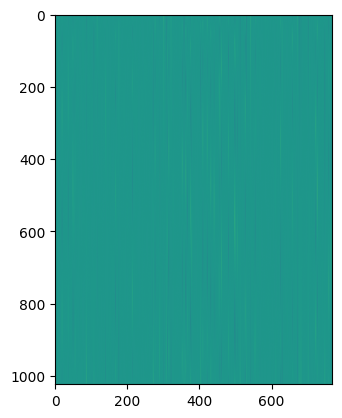

In [8]:
print(len(sd_hf["transformer.wpe.weight"].view(-1))) # --> len of flattening the wpe layer = 1024 x 768
print(sd_hf["transformer.wpe.weight"].view(-1)[:10]) # last 10 tensors for this --> probably positional embeddings of the last token

import matplotlib.pyplot as plt
plt.imshow(sd_hf["transformer.wpe.weight"]) # apparently supposed to signify something -- every row is a diff position between 0-1024


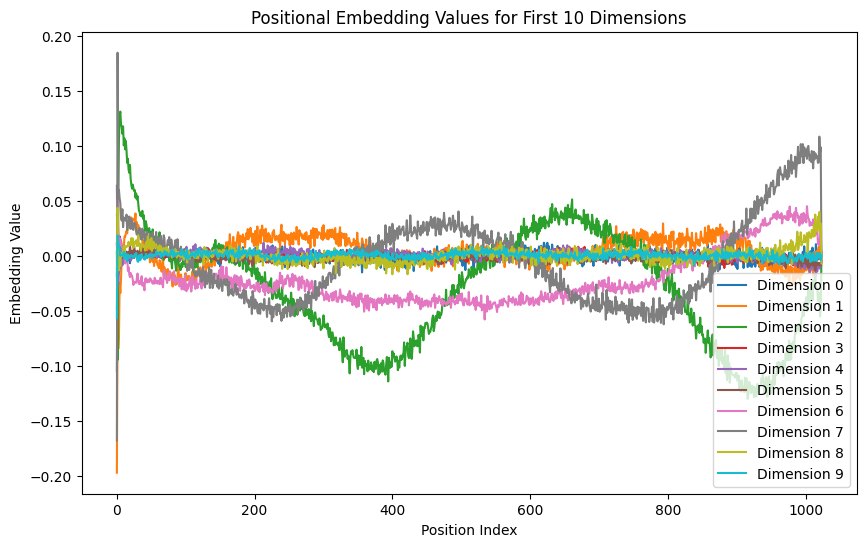

In [9]:
import matplotlib.pyplot as plt

# Let's plot the variation of the first 10 embedding dimensions across positions
wpe = sd_hf["transformer.wpe.weight"].cpu().numpy()  # shape: (1024, 768)

plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(wpe[:, i], label=f"Dimension {i}")

plt.xlabel("Position Index")
plt.ylabel("Embedding Value")
plt.title("Positional Embedding Values for First 10 Dimensions")
plt.legend()
plt.show()
# very noisy -- tells us its not fully trained -- it'll be very smooth the better the model is

In [10]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(420)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': "Hello, I'm a language model, so I'm writing for Lua.\n\nI'm a scripting language, so I'm writing with Lua.\n\nI'm a programming language, so I'm writing with Haskell.\n\nI'm a programming language, so I'm writing with Haskell.\n\nI'm a programming language, so I'm writing with Haskell.\n\nI'm a programming language, so I'm writing with Haskell.\n\nI'm a programming language, so I'm writing with Haskell.\n\nI'm a programming language, so I'm writing with Haskell.\n\nI'm a programming language, so I'm writing with Haskell.\n\nIs there anything else?\n\nI have been a member of the Lua community for a long time, so I'm really glad that you asked.\n\nI have been a member of the Lua community for a long time, so I'm really glad that you asked.\n\nIs there anything else?\n\nI have been a member of the Lua community for a long time, so I'm really glad that you asked.\n\nIs there anything else?\n\nI have been a member of the Lua community for a long time, so I'm really glad

# Actually let's write

gpt2 is a decoder only transformer -- without the middle MHA too

In [24]:
# %%writefile train_gpt2.py

from dataclasses import dataclass
import torch
import torch.nn as nn # neural network specific functions
from torch.nn import functional as F # other functions like conv or relu, etc.


class CausalSelfAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    assert config.n_embd % config.n_head == 0

    self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd) # take the vector embd and expand it to 3 more vectors --> simple linear layer expanding 1 node to 3 nodes
    self.c_proj = nn.Linear(config.n_embd, config.n_embd) # do not compress -- this is just a projection layer so that the nodes can talk to each other.
    self.n_head, self.n_embd = config.n_head, config.n_embd

    # need to add a causal mask to the attn block -- so we are only looking at the present and the past tokens
    mask = torch.tril(torch.ones(config.block_size, config.block_size))  # Lower-triangular matrix --> taking a matrix of 1s and then upper triangle is set to 0
    mask = mask.view(1, 1, config.block_size, config.block_size)         # Shape to (1, 1, T, T) instead of keeping it (T, T) --> this is the dims for attention scores
    self.register_buffer("bias", mask)                                   # Register as non-trainable buffer -- in PyTorch this registers a tensor as part of the model state, but not as a learnable parameter.

  def forward(self, x):
    B, T, C = x.size() # batch size, sequence length/num tokens, embedding dimensions/hidden size

    # calculating qkv
    # all the weights are learned together and then split -- they areall concatenated together
    W_qkv = self.c_attn(x) # this takes each token embedding vector and has it be represented as 3 vectors (q, k, v): we are passing it through a linear layer
    # W_qkv shape = B, T, (3 x n_embd) --> q, k, v all packed into the same tensor for each token embedding
    Wq, Wk, Wv = W_qkv.split(self.n_embd, dims=2) # we want to split it and extract them individually, equally across the 3rd dimension (dims=2) -- we want to keep embeddings for each token together
    # split along the embedding dimension to get back to the shape (B, T, C)
    # Wq shape = B, T, n_embd(C)
    # Wk shape = B, T, n_embd(C)
    # Wv shape = B, T, n_embd(C)
    # all the heads are packed in 1

    # NEXT --> split across the attention heads -- so that each head can process a smaller chunk of the token sequence and can process it independently
    head_dim = self.n_embd // self.n_head # calculate the size of each head which is 384 // 6 layers
    # change the dims from (B, T, C) to (B, T, n_head, head_dim)
    # then transpose so it is (B, n_head, T, head_dim) --> why do we need to do that? --> because of attention score computations that assume a certain shape for q, k matrices
    k = Wk.view(B, T, self.n_head, head_dim).transpose(1, 2) # (B, T, C) --> (B, T, n_head, head_dim) --> (B, n_head, T, head_dim)
    q = Wq.view(B, T, self.n_head, head_dim).transpose(1, 2)
    v = Wv.view(B, T, self.n_head, head_dim).transpose(1, 2)

    # NEXT --> CALC ATTENTION SCORES
    attn_scores = (q @ k.transpose(-2, -1)) / (math.sqrt(k.size(-1))) # (B, n_head, T, head_dim) @ (B, n_head, head_dim, T) --> (B, n_head, T, T)
    # (T, head_dim) x (head_dim, T) = (T x T)
    # k.size() ==> (B, n_head, T, head_dim)
    # k.size(-1) => head_dim = n_embd // n_head => d_k
    # THEN, apply the mask that we created and have stored as 'bias'
    attn_scores = attn_scores.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf')) # (B, n_head, T, T)
    attn_scores = F.softmax(attn_scores, dim=-1)
    # we want to make our token context aware: context is now stored in the attn_scores that tell us how much to attend to other tokens

    # NEXT --> gather all and exchange information
    y = attn_scores @ v # (B, n_head, T, T) @ (B, n_head, T, head_dim) --> (B, n_head, T, head_dim) : why do we do this?
    # now we want to regather all the heads
    # .contiguous helps us concatenate all attention heads together
    y = y.transpose(1, 2) # (B, n_head, T, head_dim) --> (B, T, n_head, head_dim) : so we can combine
    y = y.contiguous() # force the tensor to have a standard memory layout.
    y = y.view(B, T, C) # Then flatten last two dims (B, T, n_head, head_dim) → (B, T, C)
    y = self.c_proj(y) # (B, T, C) -> (B, T, C): Mixes the information across heads
    # contrary to mlp, this layer is not for compressing information, it is for exchanging it across all heads

    return y

class MLP(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.c_fc   = nn.Linear(config.n_embd, 4 * config.n_embd) # name means fully connected layer -- expands the network to make more sense
    self.gelu   = nn.GELU() # why not relu? the dead relu neuron problem: any activations close to 0 would be smoothed out
    # relu harshly zeros out all the negatives and is linear and rigid
    # gelu = smoother gradient flow
    self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd) # compress it back to its original dimension

  def forward(self, x):
    # return self.c_proj(self.gelu(self.c_fc(x))) --> less clean version
    x = self.c_fc(x)
    x = self.gelu(x)
    x = self.c_proj(x)
    return x


class Block(nn.Module):
  def __init__(self, config):
    super().__init__() # inheriting from nn.Module
    self.ln_1 = nn.LayerNorm(config.n_embd) # --> the goal of LayerNorm is to stabilize the learning of the model
    # goal is to make sure mean = 0 and std = 1 across all the embeddings of the token
    # input is the size of the embedding vector; batch normalization will slow thinsg down because it waits for the results from the entire batch before normalizing it
    # this is parallelizable
    self.attn = CausalSelfAttention(config)
    # layer normalization is happening
    self.ln_2 = nn.LayerNorm(config.n_embd)
    self.mlp = MLP(config)

  # the big change here from the transformer arch is that the norm layer is added to the inputs of attn/mlp layers
  # and the norm layers are removed from blocking the residual pathway -- this needs to be clean in order to form the greater context in the model : we loss context otherwise
  def forward(self, x):
    x = self.ln_1(x)
    x = x + self.attn(x) # residual connection -- the graidents that flow from the top are uninteruppted
    # also attn is a pooling function (reduce operation) -- the information is gathered and then reduced: communicated through the network
    x = self.ln_2(x)
    x = x + self.mlp(x) # the nodes individually think here and and then it i smapped to the output nodes -- it is like a map function
    return x

@dataclass
class GPTConfig:
  block_size: int = 1024 # max context length -- for a small model -- maybe the wpe part?
  vocab_size: int = 50257 # character level gpt -- number of unique characters -- maybe the wte part?
  n_layer: int = 12 # number of transformer layer
  n_head: int = 12 # number of attention heads
  n_embd: int = 768 # the embedding dimensions -- a token is represented in 384 digit vector in this case

class GPT(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    # we want to initiate an nn.module.dict which is going to be called transformer and should have transformer.wte etc.
    # these are all parts of the transformer that we want to train --> this is essentially our output
    self.transformer = nn.ModuleDict(dict(
        wte = nn.Embedding(config.vocab_size, config.n_embd),
        wpe = nn.Embedding(config.block_size, config.n_embd),
        h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # blocks of transformer layers are created according to the number of layers we have defined.
        # holding all the hidden transformer layers (includes attention layers, linear layers, mlp layers)
        # h is a list of transformer blocks -- Block class is going to be defined later
          # but essentially this contains all the attention layers, mlp layers, and layer norms that would go on top of each other.
        ln_f = nn.LayerNorm(config.n_embd) # final layer norm that is going to hold the final values that you need -- it needs to be the size of the embeddigns.
    ))

    self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # this is the final projection layer : takes the transformer output and projects it onto vocab size
    #  maps from n_embd → vocab_size -- gets predictions for each token in the vocabulary

  @classmethod
  def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True (not passed in)")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

In [25]:
model = GPT.from_pretrained("gpt2")
print("didn't crash")

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True (not passed in)
didn't crash


In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
text = "dog! dogg. dog"
tokens = tokenizer.tokenize(text)
print(tokens)
print(f"Number of tokens: {len(tokens)}")

['dog', '!', 'Ġdo', 'gg', '.', 'Ġdog']
Number of tokens: 6
